In [0]:
#  https://www.kaggle.com/lpanda/netflix-data

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import dask.dataframe as dd # asynchronous load and subset which is useful for large dataset sampling
# from dask.distributed import Client

# # visualization
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(style="whitegrid", context='paper')
# sns.set(rc={'figure.figsize':(18,5)})

# from functools import wraps # a ditty decorator

# from sklearn.metrics.pairwise import cosine_similarity

import random # random integers
import os # i/o read files
import time # time my work
import gc  # clear ram

In [0]:
# Mount drive
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/privacy'
%ls -l
print(os.listdir())

/content
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/privacy
total 2741359
-rw------- 1 root root        450 Feb 21 18:43 clean_data.py
-rw------- 1 root root      16495 Mar  7 21:26 exp_0.txt
-rw------- 1 root root      23321 Mar  8 01:26 exp_1.txt
-rw------- 1 root root          0 Mar  8 01:26 exp_2.txt
-rw------- 1 root root      17778 Mar  8 17:12 exp_3.txt
-rw------- 1 root root      15170 Mar  8 19:23 exp_4.txt
drwx------ 2 root root       4096 Feb 21 17:32 netflix-prize-data/
-rw------- 1 root root      72265 Feb 23 11:23 privacy_project.ipynb
-rw------- 1 root root      11475 Mar  7 16:44 privacy.py
drwx------ 2 root root       4096 Feb 23 10:53 __pycache__/
-rw------- 1 root root 2610540692 Feb 21 18:45 ratings.csv
-rw------- 1 root root  178846767 Mar  8 14:49 title.akas.tsv.gz
-rw------- 1 root root   17595459 Mar  8 14:47 title.ratings.tsv
['netflix-prize-data', 'clean_data.py', 'ratings.csv', '__pycache__', 'privacy_project.ipynb', 'privacy.py', '.ipy

In [0]:
%load_ext autoreload
%autoreload 1

%aimport privacy

In [0]:
# !cat netflix-prize-data/combined_data_1.txt netflix-prize-data/combined_data_2.txt netflix-prize-data/combined_data_3.txt netflix-prize-data/combined_data_4.txt | python clean_data.py >> ratings.csv

In [0]:
# !head -n 10 ratings.csv

movieId,custId,rating,date
1,1488844,3,2005-09-06
1,822109,5,2005-05-13
1,885013,4,2005-10-19
1,30878,4,2005-12-26
1,823519,3,2004-05-03
1,893988,3,2005-11-17
1,124105,4,2004-08-05
1,1248029,3,2004-04-22
1,1842128,4,2004-05-09


### Import and cleaning

In [0]:
# df = pd.read_csv('ratings.csv', nrows = 100000, index_col = 1, dtype={'movieId':np.int16, 'custId':np.int32, 'rating':np.int8, 'date':'object'})
df = pd.read_csv('ratings.csv', index_col = 1, dtype={'movieId':np.int16, 'custId':np.int32, 'rating':np.int8, 'date':'object'}, na_filter=False)
# df = pd.read_csv('ratings.csv')

print(df.memory_usage().sum()/1024**3)
# iter_csv = pd.read_csv('file.csv', iterator=True, chunksize=1000)
# df = pd.concat([chunk[chunk['field'] > constant] for chunk in iter_csv]

print(df.shape)
print(len(set(df.index)))
print(df.index.max())

1.7780155250802636
(100480507, 3)
480189
2649429


In [0]:
print(df['date'].min())
print(df['date'].max())
MIN_DATE = '1999-11-11'
MAX_DATE = '2005-12-31'
print((pd.to_datetime(MAX_DATE) - pd.to_datetime(MIN_DATE)).days)

df['days'] = ((pd.to_datetime(df['date']) - pd.to_datetime(MIN_DATE)).dt.days).astype(np.int16)
df = df.drop('date', axis=1)
# df.index = df.index.astype(np.int32)
print(df.memory_usage().sum()/1024**3)
df.head()

1999-11-11
2005-12-31
2242
1.216536938212812


,movieId,rating,days
custId,,,
1488844,1,3,2126
822109,1,5,2010
885013,1,4,2169
30878,1,4,2237
823519,1,3,1635


### Data Exploration

In [0]:
indices = df.index.value_counts()

In [0]:
len(indices.index)

480189

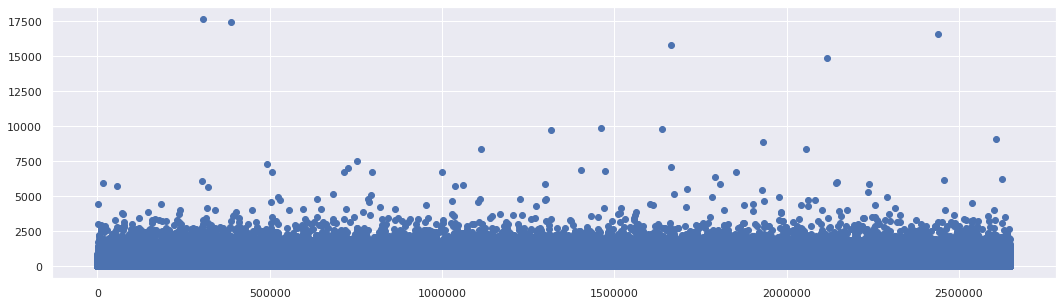

In [0]:
plt.scatter(indices.index, indices)

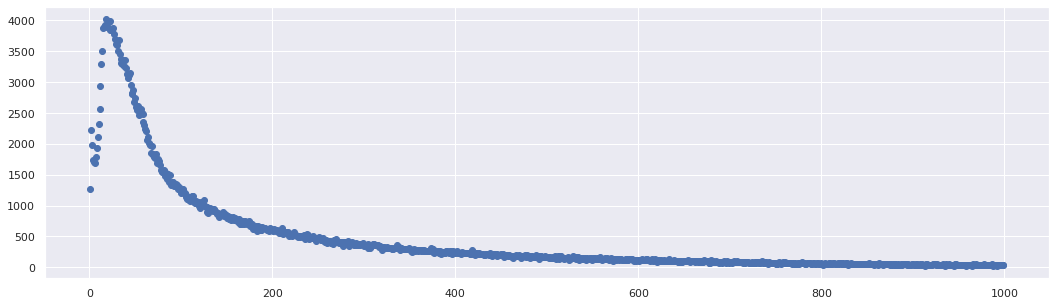

In [0]:
nb_reviews = indices.value_counts().sort_index()
plt.scatter(nb_reviews[nb_reviews.index<1000].index, nb_reviews[nb_reviews.index<1000])

### First experiment

In [0]:
np.random.seed(42)

aux_list = [privacy.Auxiliary(True, True, 0, 0), privacy.Auxiliary(True, True, 0, 0)]

aux = privacy.Generate.generate(df, aux_list, custId=None)
aux

,movieId,rating,days
custId,,,
669667,3962,4,2220
669667,12974,4,2220


In [0]:
df.loc[aux.index[0]]

,movieId,rating,days
custId,,,
669667,28,4,2220
669667,171,4,2220
669667,187,4,2220
669667,312,4,2220
669667,313,3,2220
...,...,...,...
669667,17506,3,2220
669667,17622,4,2220
669667,17627,3,2217


In [0]:
# scoring = privacy.Score_simple(privacy.equal_similarity)
# scoring = privacy.Scoreboard(privacy.equal_similarity, df)
# scoring = privacy.Scoreboard_RH(privacy.netflix_similarity(1.5,30), df)
scoring = privacy.Scoreboard_RH(privacy.general_similarity(), df)


# scoring.similarity(aux, df.loc[1488844])
scores = scoring.compute_score(aux, df)
scores

custId_2
2411208    0.362824
1164541    0.362824
482324     0.362824
912466     0.362824
669667     0.362824
             ...   
1711132    0.000000
1711143    0.000000
1711148    0.000000
1711156    0.000000
1322528    0.000000
Name: value, Length: 480189, dtype: float64

In [0]:
# scoring.matching_set(scores, 1.5)
scoring.output(scores, 0)

In [0]:
2496012
[23 28]
[30, 8]

In [0]:
movieId_list

[28, 23]

In [0]:
len(movieId_list)

2

In [0]:
record = df.loc[[2496012]]
record

,movieId,rating,days
custId,,,
2496012,23,3,992
2496012,28,3,1122


In [0]:
movieId_list = []
movieIds = np.unique(record['movieId'].values)
nb_remaining_movie_id = 2
remaining_movie_ids = list(np.random.choice(movieIds[~np.isin(movieIds, movieId_list)],
                                               size=nb_remaining_movie_id,
                                               replace=False))
movieId_list += remaining_movie_ids
movieId_list

[28, 23]

In [0]:
import inspect
lines = inspect.getsource(privacy.Generate)
print(lines)

class Generate:
    @staticmethod
    def generate(df, aux_list, custId=None, movieId_list=[]):
        """
        generate a complete auxiliary information record
        :params df: the dataframe of ratings
        :params aux_list: the informations about the records
        :params custId: the id of the customer
        :params movieId_list: the list of Id of movies to apply the aux info to
        """
        if not custId:
            custId_list = np.unique(df.index)
            
            finished = False
            while not finished:
                custId = np.random.choice(custId_list)
                if len(df.loc[[custId]]) >= len(aux_list):
                    finished = True
                
        record = df.loc[[custId]]
        movieIds = np.unique(record['movieId'].values)
        if len(record) < len(aux_list):
            raise ValueError('The customer has not reviewed enough movies')
            
        nb_remaining_movie_id = 0
        if len(movieId_list)

In [0]:
!head -n 10 exp_0.txt

### Result reproduction

In [0]:
np.random.seed(42)

nb_iterations = 100

results = {}
aux_list_list = [
                 [privacy.Auxiliary(True, True, 0, 3), privacy.Auxiliary(True, True, 0, 3)],

                 [privacy.Auxiliary(True, True, 0, 3), privacy.Auxiliary(True, True, 0, 3),
                  privacy.Auxiliary(True, True, 0, 3), privacy.Auxiliary(False, False, 0, 3)],
                 
                 [privacy.Auxiliary(True, True, 0, 3), privacy.Auxiliary(True, True, 0, 3),
                  privacy.Auxiliary(True, True, 0, 3), privacy.Auxiliary(True, True, 0, 3),
                  privacy.Auxiliary(True, True, 0, 3), privacy.Auxiliary(True, True, 0, 3),
                  privacy.Auxiliary(False, False, 0, 3), privacy.Auxiliary(False, False, 0, 3)],
                 
                 [privacy.Auxiliary(True, True, 0, 14), privacy.Auxiliary(True, True, 0, 14)],

                 [privacy.Auxiliary(True, True, 0, 14), privacy.Auxiliary(True, True, 0, 14),
                  privacy.Auxiliary(True, True, 0, 14), privacy.Auxiliary(False, False, 0, 14)],
                 
                 [privacy.Auxiliary(True, True, 0, 14), privacy.Auxiliary(True, True, 0, 14),
                  privacy.Auxiliary(True, True, 0, 14), privacy.Auxiliary(True, True, 0, 14),
                  privacy.Auxiliary(True, True, 0, 14), privacy.Auxiliary(True, True, 0, 14),
                  privacy.Auxiliary(False, False, 0, 14), privacy.Auxiliary(False, False, 0, 14)],
                 ]

for i, aux_list in enumerate(aux_list_list):
  if i==2 or i==5:
    results['exp_{}_index'.format(i)] = []
    results['exp_{}_aux'.format(i)] = []
    results['exp_{}_top_index'.format(i)] = []
    results['exp_{}_score'.format(i)] = []
    results['exp_{}_ecc'.format(i)] = []
    with open("exp_{}.txt".format(i), 'a') as f:
      f.write('custId,score,eccentricity\n')
      for k in range(nb_iterations):
        print('iteration {}'.format(k))
        aux = privacy.Generate.generate(df, aux_list, custId=None)
        scoring = privacy.Scoreboard_RH(privacy.general_similarity(), df)
        scores = scoring.compute_score(aux, df)
        top_score, ecc = scoring.matching_set(scores, 0)
        results['exp_{}_index'.format(i)].append(aux.index[0])
        results['exp_{}_aux'.format(i)].append(str(aux))
        results['exp_{}_top_index'.format(i)].append(top_score.index[0])
        results['exp_{}_score'.format(i)].append(top_score.values[0])
        results['exp_{}_ecc'.format(i)].append(ecc)
        f.write(str(aux.index[0]) + ',' + str(aux) + ',' + str(top_score.index[0]) + ',' + str(top_score.values[0]) + ',' + str(ecc) + '\n')

iteration 0
start
0
8
iteration 1
start
0
8
iteration 2
start
0
8
iteration 3
start
0
8
iteration 4
start
0
8
iteration 5
start
0
8
iteration 6
start
0
8
iteration 7
start
0
8
iteration 8
start
0
8
iteration 9
start
0
8
iteration 10
start
0
8
iteration 11
start
0
8
iteration 12
start
0
8
iteration 13
start
0
8
iteration 14
start
0
8
iteration 15
start
0
8
iteration 16
start
0
8
iteration 17
start
0
8
iteration 18
start
0
8
iteration 19
start
0
8
iteration 20
start
0
8
iteration 21
start
0
8
iteration 22
start
0
8
iteration 23
start
0
8
iteration 24
start
0
8
iteration 25
start
0
8
iteration 26
start
0
8
iteration 27
start
0
8
iteration 28
start
0
8
iteration 29
start
0
8
iteration 30
start
0
8
iteration 31
start
0
8
iteration 32
start
0
8
iteration 33
start
0
8
iteration 34
start
0
8
iteration 35
start
0
8
iteration 36
start
0
8
iteration 37
start
0
8
iteration 38
start
0
8
iteration 39
start
0
8
iteration 40
start
0
8
iteration 41
start
0
8
iteration 42
start
0
8
iteration 43
start
0


In [0]:
# Test on similarities

In [0]:
cust1 = df.loc[[1488844]].set_index('movieId', drop=True)
cust2 = df.loc[[822109]].set_index('movieId', drop=True)

In [0]:
merged = pd.merge(cust1, cust2, how='outer', left_index=True, right_index=True, suffixes=('_1', '_2'))
merged

,rating_1,days_1,rating_2,days_2
movieId,,,,
1,3,2126,5.0,2010.0
8,4,2009,NaN,NaN
17,2,2057,NaN,NaN
30,3,1980,NaN,NaN


In [0]:
merged2 = merged.copy()
merged2.loc[1, 'rating_2']=4
merged2

,rating_1,days_1,rating_2,days_2
movieId,,,,
1,3,2126,4.0,2010.0
8,4,2009,NaN,NaN
17,2,2057,NaN,NaN
30,3,1980,NaN,NaN


In [0]:
privacy.netflix_similarity(r0=1.5, d0=30)(merged)
# privacy.general_similarity(2,14)(merged)

movieId
1     0.284525
8     0.000000
17    0.000000
30    0.000000
dtype: float64

In [0]:
privacy.netflix_similarity(r0=1.5, d0=30)(merged2)

movieId
1     0.534345
8     0.000000
17    0.000000
30    0.000000
dtype: float64

In [0]:
privacy.netflix_similarity_old(r0=1.5, d0=30)(merged)

movieId
1     48.046441
8      0.000000
17     0.000000
30     0.000000
dtype: float64